In [14]:
import nltk
import numpy as np
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

nltk.download('punkt')

# Sample corpus
corpus = [
    "We are learning natural language processing",
    "Natural language processing is fun",
    "We are learning deep learning techniques",
    "Deep learning uses neural networks",
    "Neural networks are a part of deep learning",
    "Natural language processing enables machines to understand text.",
"We are learning natural language processing every day.",
"Natural language processing is really interesting.",
"We are learning about deep learning models.",
"Deep learning uses various neural networks.",
"Neural networks are commonly found in deep learning.",
"Learning natural language processing is enjoyable.",
"We are practicing deep learning techniques regularly.",
"Natural language processing involves a lot of learning.",
"Deep learning helps in building neural networks.",
"Natural language processing makes text analysis easier.",
"We enjoy learning natural language processing concepts.",
"Understanding deep learning techniques requires practice.",
"Neural networks play a crucial role in deep learning.",
"Learning natural language processing can be challenging.",
"Deep learning is an advanced field of study.",
"We need more practice with neural networks.",
"Natural language processing is an emerging technology.",
"Deep learning techniques are evolving rapidly.",
"We use neural networks to process data.",
"Understanding natural language processing is valuable.",
"Learning deep learning improves our skills.",
"Neural networks are used in various applications.",
"We find natural language processing quite exciting.",
"Mastering deep learning requires dedication.",
"Neural networks can solve complex problems.",
"Learning about natural language processing takes time.",
"Deep learning is transforming the tech industry.",
"We are studying natural language processing tools.",
"Neural networks are essential for deep learning tasks.",
"Deep learning applications rely on neural networks.",
"We are learning to implement deep learning.",
"Natural language processing is used in chatbots.",
"Deep learning and natural language processing go hand in hand.",
"Neural networks make deep learning possible.",
"Learning natural language processing has many benefits.",
"We need to understand deep learning fundamentals.",
"Deep learning involves training neural networks.",
"Neural networks are at the core of AI.",
"We are using natural language processing in projects.",
"Learning deep learning enhances our knowledge.",
"Natural language processing is a subset of AI.",
"We are interested in neural networks research.",
"Deep learning networks need a lot of data.",
"Natural language processing is quite popular nowadays.",
"We apply deep learning in different fields.",
"Understanding neural networks takes effort.",
"We aim to master natural language processing.",
"Deep learning is gaining more popularity.",
"Natural language processing helps in text classification.",
"Learning neural networks is part of our studies.",
"Deep learning algorithms are very powerful.",
"Natural language processing has many real-world uses.",
"We focus on improving deep learning techniques.",
"Neural networks enable computers to learn.",
"We explore natural language processing applications.",
"Deep learning can improve neural networks performance.",
"Learning about neural networks expands our knowledge.",
"We are exploring natural language processing research.",
"Deep learning techniques can solve complex tasks.",
"Natural language processing requires a good dataset.",
"Neural networks are essential for machine learning.",
"We are practicing deep learning programming.",
"Natural language processing uses machine learning.",
"Learning deep learning can be rewarding.",
"We are mastering neural networks fundamentals.",
"Deep learning makes machines smarter.",
"Natural language processing is used in translation.",
"We apply deep learning to improve models.",
"Neural networks are a form of deep learning.",
"Natural language processing tools are diverse.",
"We are exploring deep learning frameworks.",
"Learning about neural networks is insightful.",
"Deep learning allows for complex pattern recognition.",
"Natural language processing is a core AI component.",
"We are working on neural networks projects.",
"Understanding deep learning is vital for AI.",
"Natural language processing can automate tasks.",
"We study deep learning from various sources.",
"Neural networks mimic human brain functionality.",
"Learning about natural language processing is fulfilling.",
"Deep learning architectures are complex.",
"We apply neural networks to image processing.",
"Natural language processing can analyze sentiment.",
"Deep learning models are data-intensive.",
"We are coding neural networks from scratch.",
"Natural language processing can handle large datasets.",
"Learning deep learning opens many doors.",
"We use deep learning to build better algorithms.",
"Neural networks learn through data patterns.",
"Natural language processing is a growing field.",
"Deep learning relies heavily on neural networks.",
"We understand natural language processing better now.",
"Neural networks can perform different tasks.",
"Deep learning is used in various industries.",
"We use natural language processing for data analysis.",
"Neural networks improve as they train more.",
"Learning deep learning concepts is ongoing.",
"We apply natural language processing to improve accuracy.",
"Neural networks help solve machine learning problems.",
"Deep learning is crucial for the future of AI."
]

# Preprocess the corpus
def preprocess(corpus):
    tokens = [nltk.word_tokenize(sentence.lower()) for sentence in corpus]
    vocabulary = set([word for sentence in tokens for word in sentence])
    word2idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return tokens, word2idx, idx2word

tokens, word2idx, idx2word = preprocess(corpus)
vocab_size = len(word2idx)

[nltk_data] Downloading package punkt to /home/sheiphan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
from rich import print

In [1]:
# print(tokens, word2idx, idx2word)

In [17]:
# Generate context-target pairs
window_size = 2

def generate_pairs(tokens, window_size):
    pairs = []
    for sentence in tokens:
        for idx, word in enumerate(sentence):
            target_word = word
            context_indices = list(range(max(0, idx - window_size), idx)) + \
                              list(range(idx + 1, min(len(sentence), idx + window_size + 1)))
            context_words = [sentence[i] for i in context_indices]
            for context_word in context_words:
                pairs.append((word2idx[target_word], word2idx[context_word]))
    return pairs

pairs = generate_pairs(tokens, window_size)


In [18]:
from collections import Counter

word_counts = Counter([word for sentence in tokens for word in sentence])
total_count = sum([count for count in word_counts.values()])
word_freqs = {word: count / total_count for word, count in word_counts.items()}

# Raise to the 3/4 power
word_freqs = {word: freq ** 0.75 for word, freq in word_freqs.items()}
Z = sum(word_freqs.values())
word_freqs = {word: freq / Z for word, freq in word_freqs.items()}

word_probs = np.array([word_freqs[idx2word[i]] for i in range(vocab_size)])


In [2]:
# print(word_freqs, word_probs)

In [20]:
class Word2VecDataset(Dataset):
    def __init__(self, pairs, num_negatives):
        self.pairs = pairs
        self.num_negatives = num_negatives

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target, context = self.pairs[idx]
        negatives = np.random.choice(vocab_size, self.num_negatives, p=word_probs)
        return target, context, negatives


In [21]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.input_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self, target_word, context_word, negative_words):
        # Get embeddings
        target_embedding = self.input_embeddings(target_word)  # (batch_size, embedding_dim)
        context_embedding = self.output_embeddings(context_word)  # (batch_size, embedding_dim)
        negative_embeddings = self.output_embeddings(negative_words)  # (batch_size, num_negatives, embedding_dim)
        
        # Positive score
        positive_score = torch.mul(target_embedding, context_embedding)  # (batch_size, embedding_dim)
        positive_score = torch.sum(positive_score, dim=1)  # (batch_size)
        positive_score = torch.log(torch.sigmoid(positive_score))
        
        # Negative score
        negative_score = torch.bmm(negative_embeddings, target_embedding.unsqueeze(2)).squeeze()  # (batch_size, num_negatives)
        negative_score = torch.log(torch.sigmoid(-negative_score)).sum(1)  # (batch_size)
        
        # Combine scores
        loss = - (positive_score + negative_score)
        return loss.mean()


In [22]:
embedding_dim = 50
num_negatives = 5
batch_size = 16
num_epochs = 100
learning_rate = 0.001

dataset = Word2VecDataset(pairs, num_negatives)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Word2Vec(vocab_size, embedding_dim)

In [23]:
model.state_dict

<bound method Module.state_dict of Word2Vec(
  (input_embeddings): Embedding(196, 50)
  (output_embeddings): Embedding(196, 50)
)>

In [24]:
embedding_dim = 50
num_negatives = 5
batch_size = 16
num_epochs = 200
learning_rate = 0.001

dataset = Word2VecDataset(pairs, num_negatives)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Word2Vec(vocab_size, embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    total_loss = 0
    for target, context, negatives in dataloader:
        target = torch.LongTensor(target)
        context = torch.LongTensor(context)
        negatives = torch.LongTensor(negatives)
        
        optimizer.zero_grad()
        loss = model(target, context, negatives)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 10, Loss: 8.8996

Epoch 20, Loss: 5.5217

Epoch 30, Loss: 4.0622

Epoch 40, Loss: 3.0535

Epoch 50, Loss: 2.5277

Epoch 60, Loss: 2.0890

Epoch 70, Loss: 1.8877

Epoch 80, Loss: 1.7751

Epoch 90, Loss: 1.6592

Epoch 100, Loss: 1.6173

Epoch 110, Loss: 1.5759

Epoch 120, Loss: 1.5338

Epoch 130, Loss: 1.5285

Epoch 140, Loss: 1.5335

Epoch 150, Loss: 1.5282

Epoch 160, Loss: 1.5156

Epoch 170, Loss: 1.5065

Epoch 180, Loss: 1.5284

Epoch 190, Loss: 1.5235

Epoch 200, Loss: 1.4974

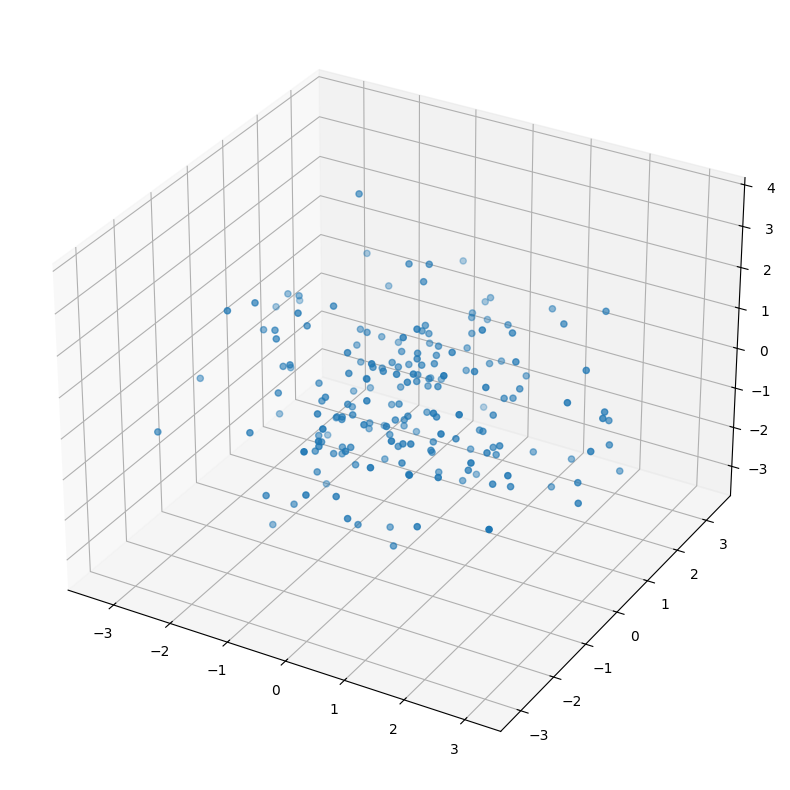

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

# Get embeddings
embeddings = model.input_embeddings.weight.detach().numpy()

# Reduce dimensions to 3 components
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
sc = ax.scatter(
    reduced_embeddings[:, 0], 
    reduced_embeddings[:, 1], 
    reduced_embeddings[:, 2],
    picker=True
)

# Annotate each point with text labels
annotations = []
for i in range(len(reduced_embeddings)):
    annotation = ax.text(
        reduced_embeddings[i, 0], 
        reduced_embeddings[i, 1], 
        reduced_embeddings[i, 2], 
        idx2word[i], 
        fontsize=8, 
        visible=False
    )
    annotations.append(annotation)

# Function to toggle annotations
def onpick(event):
    ind = event.ind[0]
    annotations[ind].set_visible(not annotations[ind].get_visible())
    fig.canvas.draw()

# Connect the event to the picker function
fig.canvas.mpl_connect('pick_event', onpick)

# Show the plot with interactive features
plt.show()


In [5]:
import torch
import torch.nn as nn

import bitsandbytes as bnb

In [25]:
import torch
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1)  # Input feature: 1, Output feature: 1

    def forward(self, x):
        out = self.linear(x)
        return out

# Prepare your dataset
X = torch.tensor([[1], [2], [3], [4], [5]])
y = torch.tensor([[2], [4], [6], [8], [10]])

# Define the model
model = LinearRegression()

# # Initialize the model
# model.linear.weight.data.fill_(1.0)
# model.linear.bias.data.fill_(0.0)

# # Define the loss function
# criterion = nn.MSELoss()

# # Define the optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# # Train the model
# num_epochs = 100
# for epoch in range(num_epochs):
#     # Forward pass
#     outputs = model(X)
#     loss = criterion(outputs, y)

#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# # Evaluate the model
# with torch.no_grad():
#     predicted = model(X)
#     print(f"Predicted: {predicted.detach().numpy().flatten()}")
#     print(f"Actual: {y.numpy().flatten()}")

In [ ]:
import torch
import bitsandbytes as bnb

mng = bnb.optim.GlobalOptimManager.get_instance()

mng.register_parameters(model.parameters())

In [27]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[-0.1708]])),
             ('linear.bias', tensor([-0.4321]))])

In [28]:
model.linear.weight

Parameter containing:
tensor([[-0.1708]], requires_grad=True)

In [29]:
model = model.cuda()
# use 8-bit optimizer states for all parameters
adam = bnb.optim.Adam(model.parameters(), lr=0.001, optim_bits=8)

# override the parameter model.fc1.weight now uses 32-bit Adam
mng.override_config(model.linear.weight, "optim_bits", 32)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx